##### 1.创建工作区

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "8_dimensionality_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

##### 2.PCA
Let's build a simple 3D dataset:

In [3]:
# 1.设置随机种子和基本参数
np.random.seed(4)
m = 60                  # 样本数量      
w1, w2 = 0.1, 0.3       # 特征权重
noise = 0.1             # 噪声

# 2.生成角度数据（-0.5π到5π/2之间的随机值）
angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5

# 3.创建特征矩阵
X = np.empty((m, 3))
# 第一个特征：cos(angles) + sin(angles)/2 + noise
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
# 第二个特征：sin(angles) * 0.7 + noise
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
# 第三个特征：第一个特征的线性组合 + noise
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

###### Principal Components

In [4]:
# 1.数据中心化（减去均值）
X_centered = X - X.mean(axis=0)

# 2.奇异值分解
U, s, Vt = np.linalg.svd(X_centered)

# 3.提取前两个主成分方向
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

SVD分解
- 将矩阵分解为 X = U * S * V^T
- U：左奇异向量矩阵
- S：奇异值矩阵（对角矩阵）：按重要性降序排列，用于确定须保留的维度
- V^T：右奇异向量矩阵的转置：描述特征之间的关系

In [5]:
# 获取数据维度
m, n = X.shape

# 创建奇异值矩阵S (与X_centered同形状)
S = np.zeros(X_centered.shape)

# 将奇异值放在对角线上
# 只使用前n个位置，因为奇异值的数量等于较小的维度
S[:n, :n] = np.diag(s)

In [6]:
# 验证SVD分解是否正确
np.allclose(X_centered, U.dot(S).dot(Vt))

True

###### Projecting Down to d Dimensions

In [7]:
# 1.提取前两个主成分方向作为投影矩阵
W2 = Vt.T[:, :2] # 形状为(n, 2)的矩阵

# 2. 将中心化数据投影到这两个方向上
X2D = X_centered.dot(W2) # 得到降维后的2D数据集

In [8]:
# 3.保存结果用于后续比较
X2D_using_svd = X2D

###### Using Scikit-Learn

With Scikit-Learn, PCA is really trivial. It even takes care of mean centering for you:

In [9]:
from sklearn.decomposition import PCA

# 创建PCA实例，设置保留2个主成分
pca = PCA(n_components=2)

# 对数据进行降维
X2D = pca.fit_transform(X)

In [10]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [11]:
print("前5个样本的降维结果:")
print("形状:", X2D_using_svd[:5].shape)
print("值:\n", X2D_using_svd[:5])

前5个样本的降维结果:
形状: (5, 2)
值:
 [[-1.26203346 -0.42067648]
 [ 0.08001485  0.35272239]
 [-1.17545763 -0.36085729]
 [-0.89305601  0.30862856]
 [-0.73016287  0.25404049]]


Notice that running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped. In this example, PCA using Scikit-Learn gives the same projection as the one given by the SVD approach, except both axes are flipped:
- PCA多次运行可能得到不同结果
- 主要区别在于坐标轴方向可能翻转
- 但数据结构/模式保持不变

In [12]:
# 验证两种方法的结果是否一致
np.allclose(X2D, -X2D_using_svd)

True

Recover the 3D points projected on the plane (PCA 2D subspace).

In [13]:
# 将降维后的数据集转换回原始维度
X3D_inv = pca.inverse_transform(X2D)

Of course, there was some loss of information during the projection step, so the recovered 3D points are not exactly equal to the original 3D points:

In [14]:
# 验证是否与原始数据集一致，降维后转回会有精度损失
np.allclose(X3D_inv, X)

False

We can compute the reconstruction error:

In [15]:
# 计算重构误差
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

The inverse transform in the SVD approach looks like this:

In [16]:
# inverse transform using SVD method
# 使用降维后的数据(X2D_using_svd)和右奇异向量(Vt)重构原始数据
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

# X2D_using_svd: 降维后的2D数据
# Vt[:2, :]: 前两个主成分对应的右奇异向量
# 结果: 重构的3D数据

The reconstructions from both methods are not identical because Scikit-Learn's `PCA` class automatically takes care of reversing the mean centering, but if we subtract the mean, we get the same reconstruction:

In [17]:
# 提取mean centering之后两个方法是相同的
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

The `PCA` object gives access to the principal components that it computed:

In [18]:
# 查看PCA主成分
print("PCA主成分矩阵形状:", pca.components_.shape)
print("\n主成分向量:")
print(pca.components_)

PCA主成分矩阵形状: (2, 3)

主成分向量:
[[-0.93636116 -0.29854881 -0.18465208]
 [ 0.34027485 -0.90119108 -0.2684542 ]]


第一主成分 [-0.93636116 -0.29854881 -0.18465208]
- 第一维度贡献: -0.937 (最大影响)
- 第二维度贡献: -0.299
- 第三维度贡献: -0.185

第二主成分 [0.34027485 -0.90119108 -0.2684542]
- 第一维度贡献: 0.340
- 第二维度贡献: -0.901 (最大影响)
- 第三维度贡献: -0.268

Compare to the first two principal components computed using the SVD method:

In [19]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

Notice how the axes are flipped.

- PCA实际上是基于SVD实现的
- SVD是一种矩阵分解方法，PCA是一种降维算法

- SVD更通用，可用于多种矩阵分解任务
- PCA专门用于降维，更易使用，PCA是scikit-learn封装的高级接口
- 底层原理相同，所以结果相似（可能有轴翻转）

###### Explained Variance Ratio

Now let's look at the explained variance ratio:

In [20]:
pca.explained_variance_ratio_
# 每个值表示每个主成分可解释的原始数据方差的比例

array([0.84248607, 0.14631839])

- The first dimension explains 84.2% of the variance, while the second explains 14.6%.

- By projecting down to 2D, we lost about 1.1% of the variance:

In [21]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

Here is how to compute the explained variance ratio using the SVD approach (recall that `s` is the diagonal of the matrix `S`):

In [22]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

Next, let's generate some nice figures! :)

**Code to generate Figure 8–2. A 3D dataset lying close to a 2D subspace:**

In [23]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        super().draw(renderer)
        
    def do_3d_projection(self, renderer=None):
        if renderer is None:
            return np.min(self._verts3d[2])
            
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        return np.min(zs)

Express the plane as a function of x and y.

In [24]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_     # 主成分矩阵
R = C.T.dot(C)          # 投影矩阵

# 计算对应的3D坐标
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

Plot the 3D dataset, the plane and the projections on that plane.

C:\Users\周悦\AppData\Local\Temp\ipykernel_15732\3155742340.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")


Saving figure dataset_3d_plot


C:\Users\周悦\AppData\Local\Temp\ipykernel_15732\1529711942.py:11: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


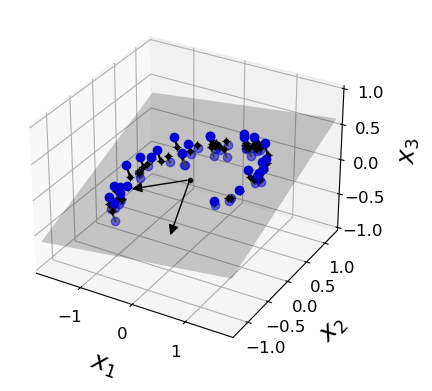

In [25]:
from mpl_toolkits.mplot3d import Axes3D

# 1.创建3D图形
fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

# 2.区分数据点位置
X3D_above = X[X[:, 2] > X3D_inv[:, 2]]      # 在投影面上方的点
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]     # 在投影面下方的点

# 3.绘制点和投影平面
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)

# 4.添加主成分方向箭头
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

# 5.绘制投影连接线
for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")

# 6.绘制投影点和其他点    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")

# 7.设置坐标轴
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

# 8.保存并显示图形
save_fig("dataset_3d_plot")
plt.show()

**Code to generate Figure 8–3. The new 2D dataset after projection:**

Saving figure dataset_2d_plot


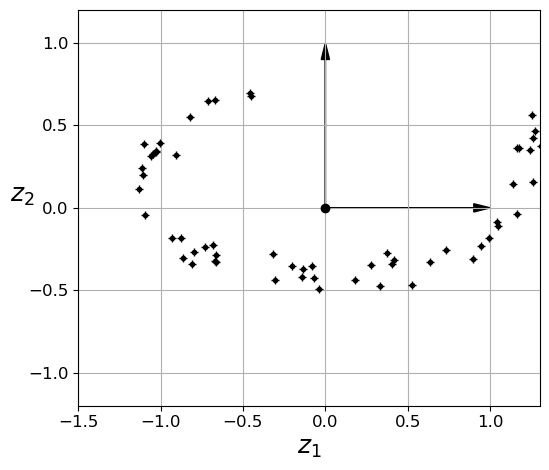

In [26]:
# 1. 创建等比例图形
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

# 2. 绘制降维后的数据点
ax.plot(X2D[:, 0], X2D[:, 1], "k+")  # 加号标记
ax.plot(X2D[:, 0], X2D[:, 1], "k.")  # 点标记

# 3. 绘制原点和主成分方向
ax.plot([0], [0], "ko")  # 原点
# 绘制垂直箭头（第一主成分）
ax.arrow(0, 0, 0, 1, 
         head_width=0.05, 
         length_includes_head=True, 
         head_length=0.1, 
         fc='k', ec='k')
# 绘制水平箭头（第二主成分）         
ax.arrow(0, 0, 1, 0, 
         head_width=0.05, 
         length_includes_head=True, 
         head_length=0.1, 
         fc='k', ec='k')

# 4. 设置图形属性
ax.set_xlabel("$z_1$", fontsize=18)  # x轴标签
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)  # y轴标签
ax.axis([-1.5, 1.3, -1.2, 1.2])  # 坐标轴范围
ax.grid(True)  # 显示网格

# 5. 保存并显示
save_fig("dataset_2d_plot")

**Code to generate Figure 8–4. Swiss roll dataset:**

In [27]:
from sklearn.datasets import make_swiss_roll
import numpy as np

# 生成Swiss Roll数据
X, t = make_swiss_roll(
    n_samples=1000,    # 样本数量
    noise=0.2,         # 噪声水平
    random_state=42    # 随机种子
)

print("数据形状:", X.shape)
print("参数t形状:", t.shape)

数据形状: (1000, 3)
参数t形状: (1000,)


Saving figure swiss_roll_plot


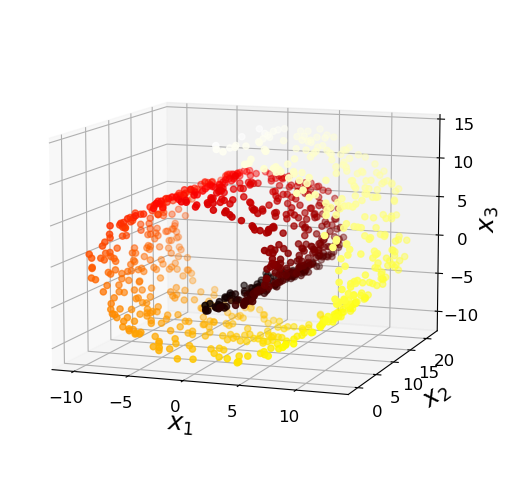

In [28]:
# 1. 定义坐标轴范围
axes = [-11.5, 14, -2, 23, -12, 15]

# 2. 创建3D图形
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

# 3. 绘制散点图
ax.scatter(X[:, 0], X[:, 1], X[:, 2], 
          c=t,                # 使用t参数作为颜色映射
          cmap=plt.cm.hot)   # 使用热力图配色

# 4. 设置视角和标签
ax.view_init(10, -70)        # 设置观察角度
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)

# 5. 设置坐标轴范围
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# 6. 保存和显示
save_fig("swiss_roll_plot")
plt.show()

**Code to generate Figure 8–5. Squashing by projecting onto a plane (left) versus unrolling the Swiss roll (right):**

Saving figure squished_swiss_roll_plot


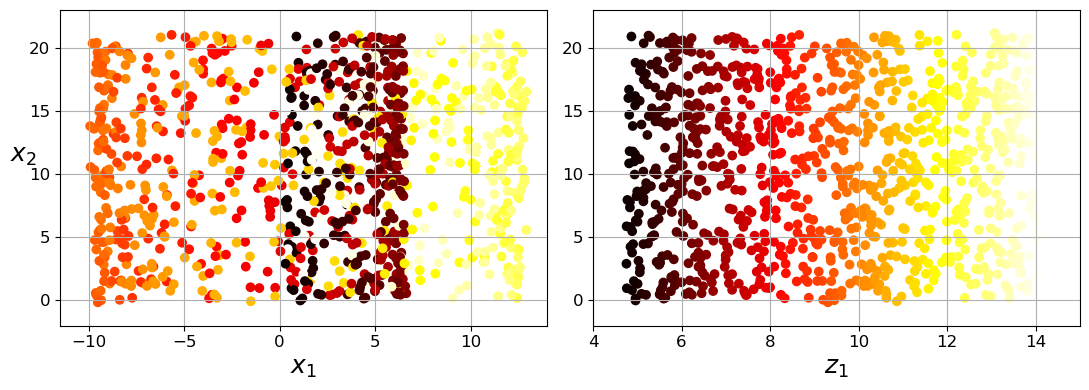

In [49]:
# 创建11x4大小的图
plt.figure(figsize=(11, 4))

# 左图：x1-x2平面投影
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)  # 使用t参数作为颜色映射
plt.axis(axes[:4])  # 设置坐标轴范围
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

# 右图：展开后的数据
plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)  # 使用t参数作为颜色映射
plt.axis([4, 15, axes[2], axes[3]])  # 设置坐标轴范围
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

# 保存和显示图形
save_fig("squished_swiss_roll_plot")
plt.show()

**Code to generate Figure 8–6. The decision boundary may not always be simpler with lower dimensions:**

Saving figure manifold_decision_boundary_plot1


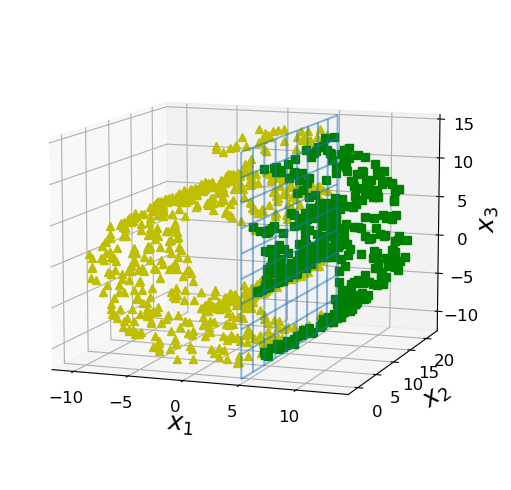

Saving figure manifold_decision_boundary_plot2


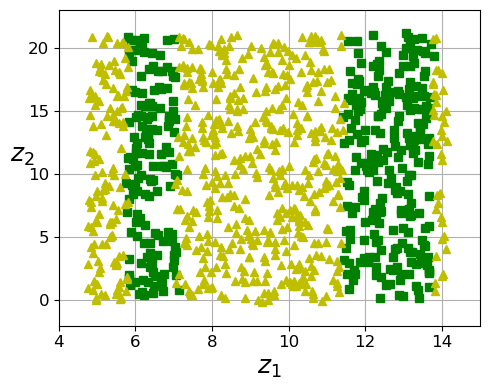

Saving figure manifold_decision_boundary_plot3


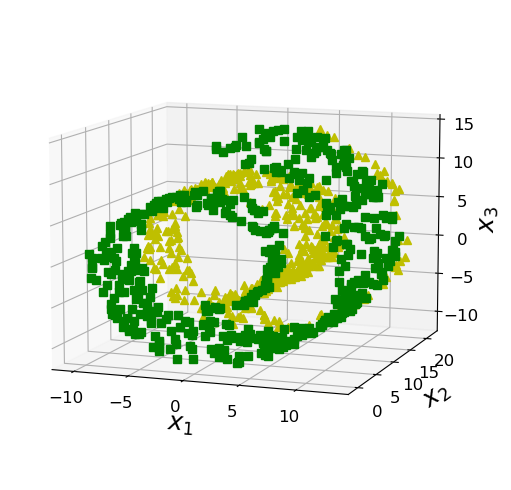

Saving figure manifold_decision_boundary_plot4


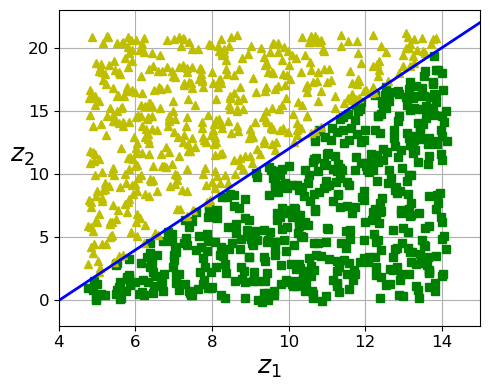

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

# 生成Swiss Roll数据
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

# 设置坐标轴范围
axes = [-11.5, 14, -2, 23, -12, 15]

# 创建网格
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

# 1. 绘制第一个3D图形
fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot1")
plt.show()

# 2. 绘制第一个2D图形
fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot2")
plt.show()

# 3. 绘制第二个3D图形
fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot3")
plt.show()

# 4. 绘制第二个2D图形
fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot4")
plt.show()

**Code to generate Figure 8–7. Selecting the subspace to project on:**

Saving figure pca_best_projection_plot


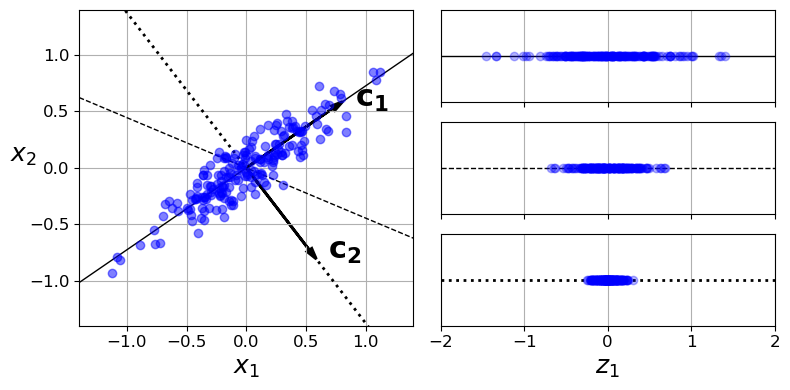

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# 生成数据
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0], [0, 1]]))  # 拉伸
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])  # 旋转

# 定义投影方向
u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

# 计算投影
X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

# 创建图形
plt.figure(figsize=(8, 4))

# 主图：原始数据和投影方向
plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.05, linewidth=2, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.05, linewidth=2, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

# 投影图1
plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

# 投影图2
plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

# 投影图3
plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

# 保存并显示图形
save_fig("pca_best_projection_plot")
plt.show()

###### choosing the right number of dimensions

**Warning:** since Scikit-Learn 0.24, `fetch_openml()` returns a Pandas `DataFrame` by default. To avoid this and keep the same code as in the book, we set `as_frame=True`.

In [32]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

C:\Users\周悦\AppData\Roaming\Python\Python39\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [33]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [52]:
from sklearn.decomposition import PCA

# 假设X_train是训练数据
pca = PCA()
pca.fit(X_train)

# 计算累计解释方差比例
cumsum = np.cumsum(pca.explained_variance_ratio_)

# 确定保留95%方差所需的主成分数量
d = np.argmax(cumsum >= 0.95) + 1

print(f"保留95%方差所需的主成分数量: {d}")

保留95%方差所需的主成分数量: 154


In [53]:
d

154

**Code to generate Figure 8–8. Explained variance as a function of the number of dimensions:**

Saving figure explained_variance_plot


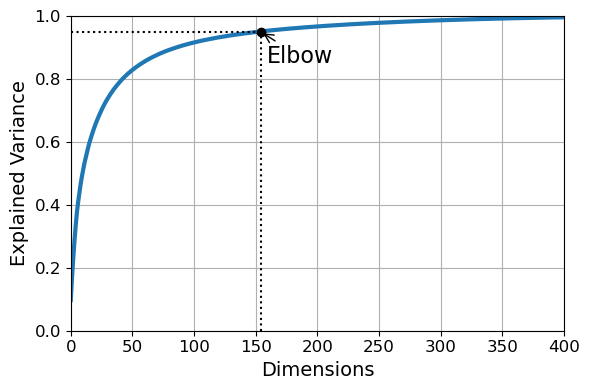

In [54]:
plt.figure(figsize=(6, 4))

# 绘制累计解释方差比例曲线
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")

# 标注保留95%方差所需的主成分数量
plt.plot([d, d], [0, 0.95], "k:")  # 垂直虚线
plt.plot([0, d], [0.95, 0.95], "k:")  # 水平虚线
plt.plot(d, 0.95, "ko")  # 标记点

# 添加注释
plt.annotate("Elbow", xy=(d, 0.95), xytext=(d + 5, 0.85),
             arrowprops=dict(arrowstyle="->"), fontsize=16)

# 显示网格
plt.grid(True)

# 保存并显示图形
save_fig("explained_variance_plot")
plt.show()

In [56]:
from sklearn.decomposition import PCA

# 使用PCA降维，保留95%的方差
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

print(f"降维后的数据形状: {X_reduced.shape}")
print(f"降维前的数据形状: {X_train.shape}")

降维后的数据形状: (52500, 154)
降维前的数据形状: (52500, 784)


In [38]:
pca.n_components_ # 返回保留95%方差所需的主成分数量

154

In [39]:
np.sum(pca.explained_variance_ratio_)

0.9504334914295707

###### PCA for compression

In [57]:
from sklearn.decomposition import PCA

# 使用PCA降维到154个主成分
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)

# 将降维后的数据还原到原始空间
X_recovered = pca.inverse_transform(X_reduced)

print(f"降维后的数据形状: {X_reduced.shape}")
print(f"还原后的数据形状: {X_recovered.shape}")

降维后的数据形状: (52500, 154)
还原后的数据形状: (52500, 784)


**Code to generate Figure 8–9. MNIST compression that preserves 95% of the variance:**

In [41]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28  # 每个图像的大小是28×28像素
    images_per_row = min(len(instances), images_per_row)  # 每行显示的图像数量，不能超过总图像数

    # 计算需要的行数，等价于 n_rows = ceil(len(instances) / images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 如果图像数量不能整除每行图像数，填充空白图像
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 将图像数组重塑为网格形式，每个图像是28×28像素
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 将网格的轴重新排列，以便可以组合成一个大图像
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size, images_per_row * size)

    # 显示大图像
    plt.imshow(big_image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

Saving figure mnist_compression_plot


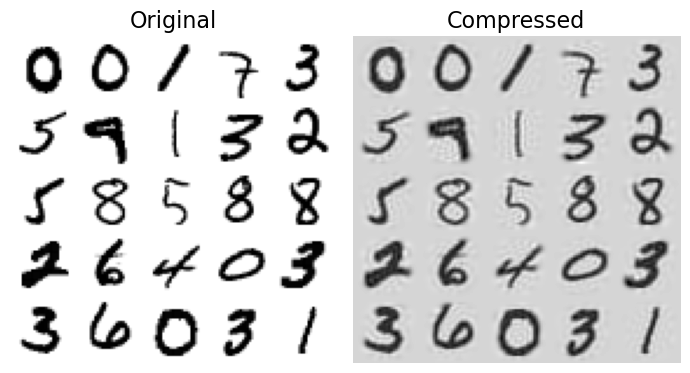

In [58]:
plt.figure(figsize=(7, 4))

# 左图：原始图像
plt.subplot(121)
plot_digits(X_train[::2100])  # 每隔2100个样本取一个
plt.title("Original", fontsize=16)

# 右图：压缩后的图像
plt.subplot(122)
plot_digits(X_recovered[::2100])  # 每隔2100个样本取一个
plt.title("Compressed", fontsize=16)

# 保存并显示图形
save_fig("mnist_compression_plot")
plt.show()

In [43]:
X_reduced_pca = X_reduced

###### Randomized PCA

In [59]:
from sklearn.decomposition import PCA

# 使用随机化PCA降维到154个主成分
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

print(f"降维后的数据形状: {X_reduced.shape}")

降维后的数据形状: (52500, 154)


###### Incremental PCA
- IncrementalPCA: 增量PCA适用于大规模数据集，通过逐批处理数据来进行降维。

In [61]:
from sklearn.decomposition import IncrementalPCA
import numpy as np

# 假设X_train是训练数据
n_batches = 100  # 将数据分成100批
inc_pca = IncrementalPCA(n_components=154)  # 设置主成分数量为154

# 逐批拟合数据
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="")  # 显示进度
    inc_pca.partial_fit(X_batch)

# 对整个训练数据进行降维
X_reduced = inc_pca.transform(X_train)

print(f"\n降维后的数据形状: {X_reduced.shape}")

....................................................................................................
降维后的数据形状: (52500, 154)


In [62]:
# 使用增量PCA还原降维后的数据
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

print(f"还原后的数据形状: {X_recovered_inc_pca.shape}")

还原后的数据形状: (52500, 784)


Let's check that compression still works well:

Saving figure mnist_incremental_pca_plot


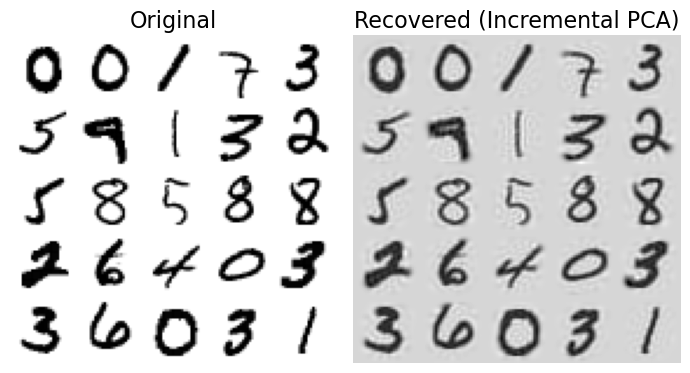

In [65]:
plt.figure(figsize=(7, 4))

# 左图：原始图像
plt.subplot(121)
plot_digits(X_train[::2100])  # 每隔2100个样本取一个
plt.title("Original", fontsize=16)

# 右图：增量PCA还原后的图像
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])  # 每隔2100个样本取一个
plt.title("Recovered (Incremental PCA)", fontsize=16)

# 调整布局
plt.tight_layout()

# 保存并显示图形
save_fig("mnist_incremental_pca_plot")
plt.show()

In [66]:
X_reduced_inc_pca = X_reduced

Let's compare the results of transforming MNIST using regular PCA and incremental PCA. First, the means are equal: 

In [67]:
np.allclose(pca.mean_, inc_pca.mean_)

True

But the results are not exactly identical. Incremental PCA gives a very good approximate solution, but it's not perfect:

In [68]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

**Using `memmap()`:**
- 内存映射Memory Mapping是一种将文件内容直接映射到进程的虚拟内存地址空间的技术。通过内存映射，可以将文件的一部分或全部内容映射到内存中，允许程序像访问内存一样访问文件内容。

Let's create the `memmap()` structure and copy the MNIST data into it. This would typically be done by a first program:

In [72]:
import numpy as np

# 假设X_train是训练数据
filename = "memmap_mnist.data"
m, n = X_train.shape

# 创建内存映射文件
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))

# 将训练数据写入内存映射文件
X_mm[:] = X_train[:]

# 确保数据写入磁盘
X_mm.flush()

print(f"数据已写入内存映射文件: {filename}")

数据已写入内存映射文件: memmap_mnist.data


Now deleting the `memmap()` object will trigger its Python finalizer, which ensures that the data is saved to disk.

In [73]:
del X_mm # 删除内存映射文件对象

Next, another program would load the data and use it for training:

In [75]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

n_batches = 100
batch_size = m // n_batches # 每批的样本数量为60000/100=600，100是批次数
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size) # 设置主成分数量为154
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

**Time complexity:**

Let's time regular PCA against Incremental PCA and Randomized PCA, for various number of principal components:

In [76]:
import time
from sklearn.decomposition import PCA, IncrementalPCA

# 假设X_train是训练数据

# 循环设置不同的主成分数量：2, 10, 154
for n_components in (2, 10, 154):
    print("n_components =", n_components)
    
    # 创建不同的PCA对象
    regular_pca = PCA(n_components=n_components, svd_solver="full")
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    # 比较三种PCA算法的运行时间
    for name, pca in (("PCA", regular_pca), ("Inc PCA", inc_pca), ("Rnd PCA", rnd_pca)):
        t1 = time.time() # 记录开始时间
        pca.fit(X_train)
        t2 = time.time() # 记录结束时间
        print("    {}: {:.1f} seconds".format(name, t2 - t1))

n_components = 2
    PCA: 4.1 seconds
    Inc PCA: 17.5 seconds
    Rnd PCA: 1.1 seconds
n_components = 10
    PCA: 7.1 seconds
    Inc PCA: 22.4 seconds
    Rnd PCA: 0.9 seconds
n_components = 154
    PCA: 4.7 seconds
    Inc PCA: 23.8 seconds
    Rnd PCA: 4.3 seconds


Now let's compare PCA and Randomized PCA for datasets of different sizes (number of instances):

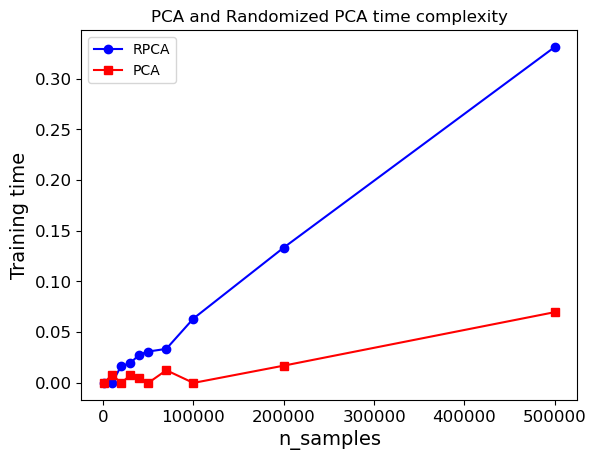

In [77]:
import numpy as np
import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 初始化时间列表
times_rpca = []
times_pca = []

# 定义样本数量列表
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]

# 循环不同的样本数量
for n_samples in sizes:
    # 生成随机数据
    X = np.random.randn(n_samples, 5)
    
    # 随机化PCA
    pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    
    # 标准PCA
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

# 绘制训练时间曲线
plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity")
plt.show()

# 随机化PCA在高维数据上优势明显
# 低维数据上（代码中的特征维度只有5维），标准PCA可能更快
# 选择PCA方法时需考虑数据的维度特征

And now let's compare their performance on datasets of 2,000 instances with various numbers of features:

In [79]:
# 初始化时间记录列表
times_rpca = []  # 记录随机化PCA时间
times_pca = []   # 记录标准PCA时间

# 设置不同的特征维度
sizes = [1000, 2000, 3000, 4000, 5000, 6000]

# 对每个特征维度进行测试
for n_features in sizes:
    # 生成固定样本数(2000)、不同特征维度的随机数据
    X = np.random.randn(2000, n_features)
    
    # 测试随机化PCA
    pca = PCA(n_components=2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    
    # 测试标准PCA
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

##### 3.Kernal PCA

核PCA与标准PCA的主要区别
- 处理能力
    - PCA：只能处理线性可分的数据
    - 核PCA：可以处理非线性数据
- 工作原理
    - PCA：直接在原始空间进行线性变换
    - 核PCA：使用核技巧将数据映射到高维空间，再进行PCA
- 核函数选择
    - RBF核：适用于一般非线性数据
    - 多项式核：适用于多项式关系数据
    - 线性核：等同于标准PCA
    - Sigmoid核：类似神经网络
- 应用场景
    - PCA:线性降维、数据压缩
    - 核PCA:非线性降维、特征提取

In [80]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [81]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

**Code to generate Figure 8–10. Swiss roll reduced to 2D using kPCA with various kernels:**

Saving figure kernel_pca_plot


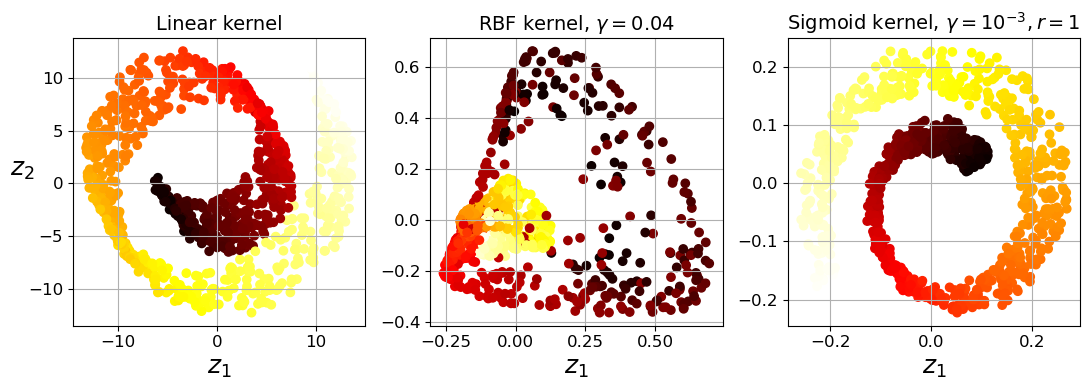

In [83]:
from sklearn.decomposition import KernelPCA

# 创建三种核PCA对象
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

# 创建标签
y = t > 6.9 # 如果大于6.9，标签为True

# 绘制三种核PCA的图形
plt.figure(figsize=(11, 4))

# 绘制三种核函数的结果
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), 
                            (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    
    # 降维
    X_reduced = pca.fit_transform(X)
    
    # 保存RBF核PCA的结果
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    # 绘制子图
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

# 结论：RBF核PCA在Swiss Roll数据集上表现最好

**Code to generate Figure 8–11. Kernel PCA and the reconstruction pre-image error:**

Saving figure preimage_plot


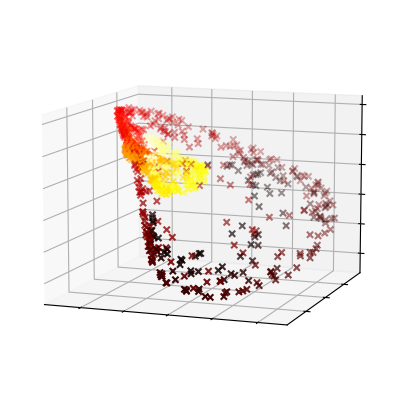

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# 创建图形
plt.figure(figsize=(6, 5))

# RBF核PCA逆变换
X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

# 创建3D子图
ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)  # 设置视角

# 绘制散点图
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], 
          c=t,                # 使用t值作为颜色映射
          cmap=plt.cm.hot,    # 热力图配色
          marker="x")         # 使用x标记

# 设置坐标轴
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# 保存并显示图形
save_fig("preimage_plot", tight_layout=False)
plt.show()

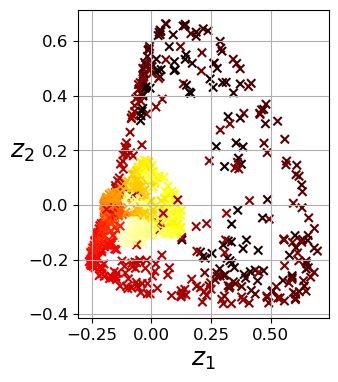

In [85]:
# 使用RBF核PCA降维
X_reduced = rbf_pca.fit_transform(X)

# 创建图形
plt.figure(figsize=(11, 4))
plt.subplot(132)  # 创建子图

# 绘制散点图
plt.scatter(X_reduced[:, 0],     # 第一主成分
           X_reduced[:, 1],      # 第二主成分
           c=t,                  # 使用t值作为颜色
           cmap=plt.cm.hot,      # 热力图配色
           marker="x")           # x标记

# 设置标签和网格
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

###### Selecting a Kernel and Tuning Hyperparameters

In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np

# 创建管道
clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression(solver="lbfgs"))
])

# 设置参数网格
param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),  # gamma参数范围
    "kpca__kernel": ["rbf", "sigmoid"]            # 核函数类型
}]

# 执行网格搜索
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

# 获取最佳参数
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}
Best score: 0.9320038601475726


In [87]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [90]:
from sklearn.decomposition import KernelPCA
import numpy as np

# 创建RBF核PCA对象
rbf_pca = KernelPCA(
    n_components=2,             # 降至2维
    kernel="rbf",              # 使用RBF核
    gamma=0.0433,              # gamma参数
    fit_inverse_transform=True  # 启用逆变换
)

# 执行降维
X_reduced = rbf_pca.fit_transform(X)

# 执行逆变换
X_preimage = rbf_pca.inverse_transform(X_reduced)

# 计算重建误差
reconstruction_error = np.mean(np.sum(np.square(X - X_preimage), axis=1))
print(f"重建误差: {reconstruction_error}")
# 重建误差:原始数据与重建数据的平方距离总和的均值

重建误差: 98.35892638729841


In [91]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576614

reconstruction_error和mse确实有联系
- 差异在于特征维度的处理方式不同
- 对于3维数据，reconstruction_error约等于3倍的mse
- 这是因为reconstruction_error在计算时保留了维度信息，而mse直接平均了所有维度

##### 4.LLE 局部线性嵌入 LocallyLinearEmbedding

In [93]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [94]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

**Code to generate Figure 8–12. Unrolled Swiss roll using LLE:**

Saving figure lle_unrolling_plot


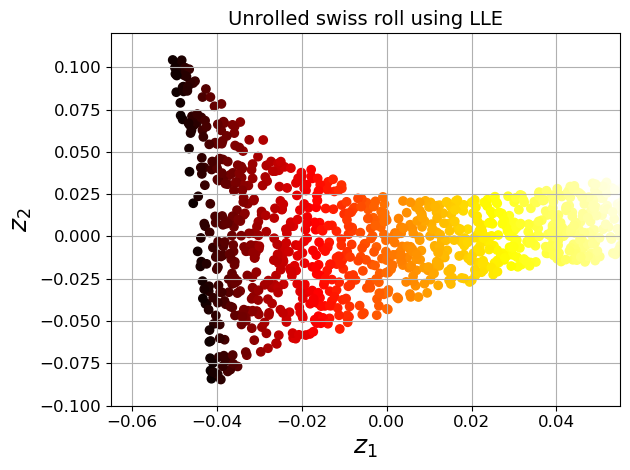

In [96]:
import matplotlib.pyplot as plt

# 创建图形并设置标题
plt.title("Unrolled swiss roll using LLE", fontsize=14)

# 绘制散点图
plt.scatter(X_reduced[:, 0],     # LLE降维后的第一维
           X_reduced[:, 1],      # LLE降维后的第二维
           c=t,                  # 使用t参数作为颜色映射
           cmap=plt.cm.hot)      # 使用热力图配色

# 设置轴标签
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)

# 设置坐标轴范围
plt.axis([-0.065, 0.055, -0.1, 0.12])

# 显示网格
plt.grid(True)

# 保存并显示图形
save_fig("lle_unrolling_plot")
plt.show()

##### 5.Other dimensionality reduction techniques 

In [97]:
# MDS 多维缩放 multiple dimensional scaling 是一种保持样本之间距离的降维技术
from sklearn.manifold import MDS
import numpy as np

# 创建MDS对象并设置参数
mds = MDS(
    n_components=2,    # 降至2维
    random_state=42    # 设置随机种子
)

# 执行降维
X_reduced_mds = mds.fit_transform(X)

# 打印形状变化
print(f"原始数据形状: {X.shape}")
print(f"降维后数据形状: {X_reduced_mds.shape}")

C:\Users\周悦\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


原始数据形状: (1000, 3)
降维后数据形状: (1000, 2)


In [98]:
# Isomap 等距映射，是一种测地距离保持的非线性降维技术
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [99]:
# T-SNE t分布随机邻域嵌入 t-distributed Stochastic Neighbor Embedding
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [100]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 创建LDA对象
lda = LinearDiscriminantAnalysis(n_components=2)  # 降至2维

# 获取MNIST数据
X_mnist = mnist["data"]    # 图像数据
y_mnist = mnist["target"]  # 标签

# 拟合并转换数据
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

# 检查数据形状
print(f"原始数据形状: {X_mnist.shape}")
print(f"降维后数据形状: {X_reduced_lda.shape}")

原始数据形状: (70000, 784)
降维后数据形状: (70000, 2)


**Code to generate Figure 8–13. Using various techniques to reduce the Swill roll to 2D:**

Saving figure other_dim_reduction_plot


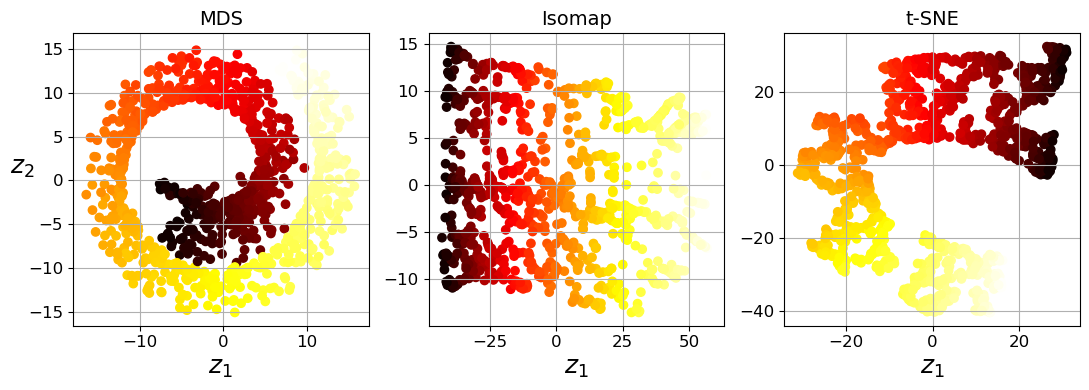

In [101]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()

# 对于Swiss Roll数据集:
    # Isomap效果最好，既保持了局部结构又保留了全局信息
    # t-SNE次之，局部结构保持得好但可能丢失部分全局信息
    # MDS效果最差，难以很好地展开非线性结构

##### 6.练习题

9.加载MNIST数据集（在第3章中介绍），并将其分为训练集和测试集（使用前60 000个实例进行训练，其余10 000个进行测试）。在数据集上训练随机森林分类器，花费多长时间，然后在测试集上评估模型。接下来，使用PCA来减少数据集的维度，可解释方差率为95%。在精简后的数据集上训练新的随机森林分类器，查看花费了多长时间。训练速度提高了吗？接下来，评估测试集上的分类器。与之前的分类器相比如何？

The MNIST dataset was loaded earlier.

In [102]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

*Exercise: Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set.*

In [103]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [104]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [105]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 54.88s


In [106]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

*Exercise: Next, use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%.*

In [107]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

*Exercise: Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster?*

In [108]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [109]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 212.96s


Oh no! Training is actually more than twice slower now! How can that be? Well, as we saw in this chapter, dimensionality reduction does not always lead to faster training time: it depends on the dataset, the model and the training algorithm. See figure 8-6 (the `manifold_decision_boundary_plot*` plots above). If you try a softmax classifier instead of a random forest classifier, you will find that training time is reduced by a factor of 3 when using PCA. Actually, we will do this in a second, but first let's check the precision of the new random forest classifier.

*Exercise: Next evaluate the classifier on the test set: how does it compare to the previous classifier?*

In [110]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

It is common for performance to drop slightly when reducing dimensionality, because we do lose some useful signal in the process. However, the performance drop is rather severe in this case. So PCA really did not help: it slowed down training and reduced performance. :(

Let's see if it helps when using softmax regression:

In [111]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

C:\Users\周悦\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [112]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 7.41s


In [113]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

Okay, so softmax regression takes much longer to train on this dataset than the random forest classifier, plus it performs worse on the test set. But that's not what we are interested in right now, we want to see how much PCA can help softmax regression. Let's train the softmax regression model using the reduced dataset:

In [114]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

C:\Users\周悦\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [115]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 2.65s


Nice! Reducing dimensionality led to over 2× speedup. :)  Let's check the model's accuracy:

In [116]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

A very slight drop in performance, which might be a reasonable price to pay for a 2× speedup, depending on the application.

So there you have it: PCA can give you a formidable speedup... but not always!

10.使用t-SNE将MNIST数据集降至两个维度，然后用Matplotlib绘制结果。你可以通过散点图用10个不同的颜色来代表每个图像的目标类，或者也可以用对应实例的类（从0到9的数字）替换散点图中的每个点，甚至你还可以绘制数字图像本身的缩小版（如果你绘制所有数字，视觉效果会太凌乱，所以你要么绘制一个随机样本，要么选择单个实例，但是这个实例的周围最好没有其他绘制的实例）。现在你应该得到了一个很好的可视化结果及各自分开的数字集群。尝试使用其他降维算法，如PCA、LLE或MDS等，比较可视化结果。

*Exercise: Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class.*

The MNIST dataset was loaded above.

Dimensionality reduction on the full 60,000 images takes a very long time, so let's only do this on a random subset of 10,000 images:

In [117]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

Now let's use t-SNE to reduce dimensionality down to 2D so we can plot the dataset:

In [118]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

Now let's use Matplotlib's `scatter()` function to plot a scatterplot, using a different color for each digit:

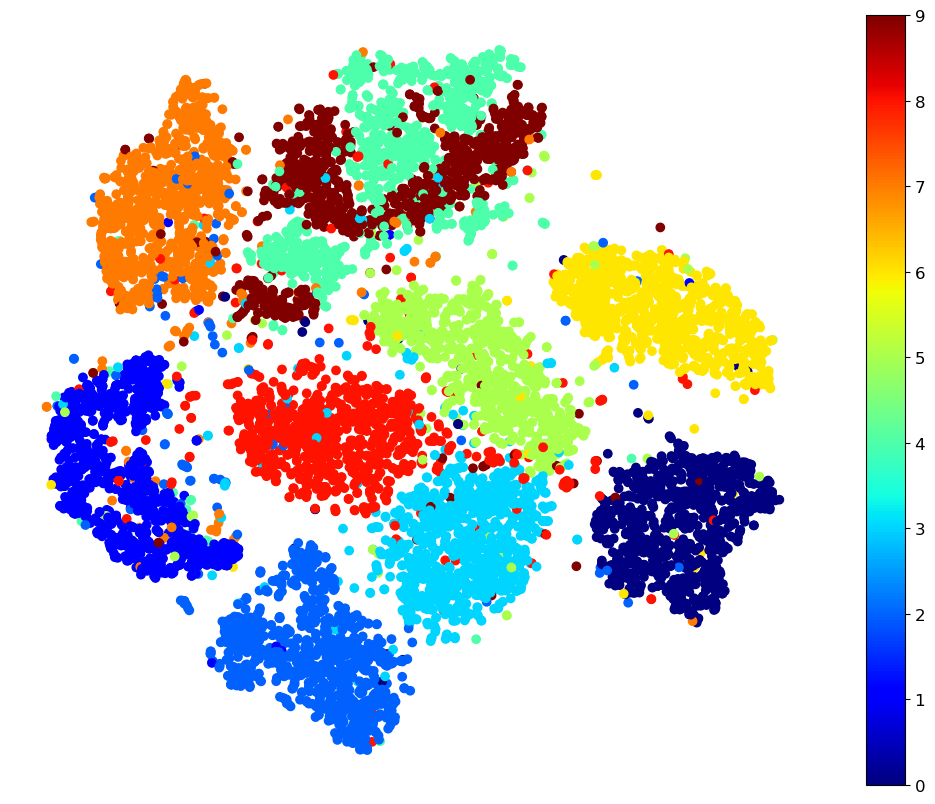

In [119]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

Isn't this just beautiful? :) This plot tells us which numbers are easily distinguishable from the others (e.g., 0s, 6s, and most 8s are rather well separated clusters), and it also tells us which numbers are often hard to distinguish (e.g., 4s and 9s, 5s and 3s, and so on).

Let's focus on digits 2, 3 and 5, which seem to overlap a lot.

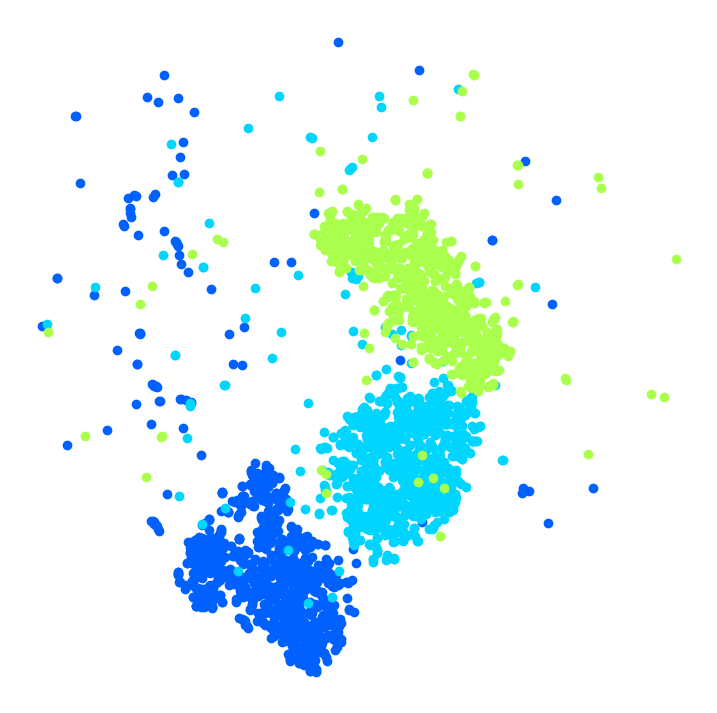

In [120]:
plt.figure(figsize=(9,9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

Let's see if we can produce a nicer image by running t-SNE on these 3 digits:

In [121]:
idx = (y == 2) | (y == 3) | (y == 5) 
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

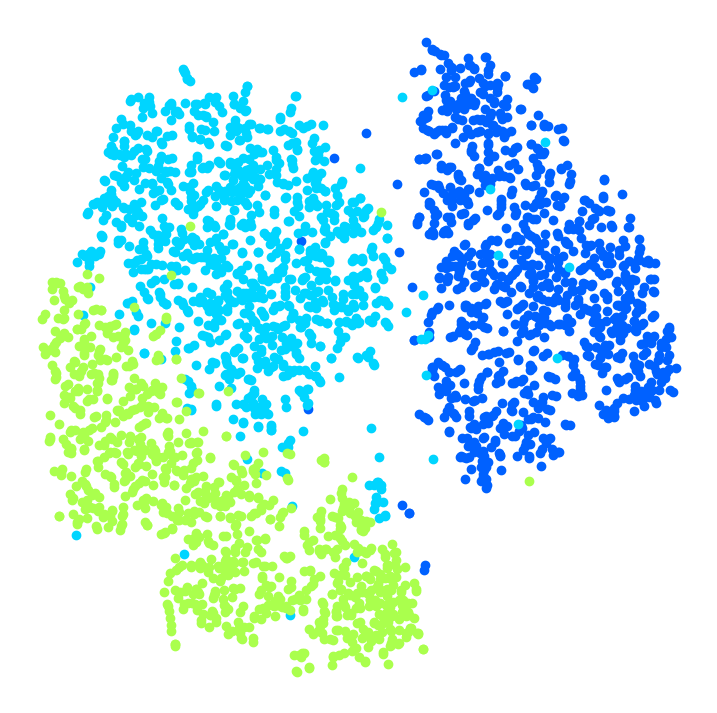

In [122]:
plt.figure(figsize=(9,9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

Much better, now the clusters have far less overlap. But some 3s are all over the place. Plus, there are two distinct clusters of 2s, and also two distinct clusters of 5s. It would be nice if we could visualize a few digits from each cluster, to understand why this is the case. Let's do that now. 

*Exercise: Alternatively, you can write colored digits at the location of each instance, or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits.*

Let's create a `plot_digits()` function that will draw a scatterplot (similar to the above scatterplots) plus write colored digits, with a minimum distance guaranteed between these digits. If the digit images are provided, they are plotted instead. This implementation was inspired from one of Scikit-Learn's excellent examples ([plot_lle_digits](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html), based on a different digit dataset).

让我们创建一个`plot_digits（）`函数，它将绘制散点图（类似于上述散点图）并写入彩色数字，保证这些数字之间的最小距离。如果提供了数字图像，则将其绘制出来。此实现的灵感来自Scikit-Learn的一个优秀示例（[plot_lle_digits](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html)，基于不同的数字数据集）。

In [123]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

Let's try it! First let's just write colored digits:

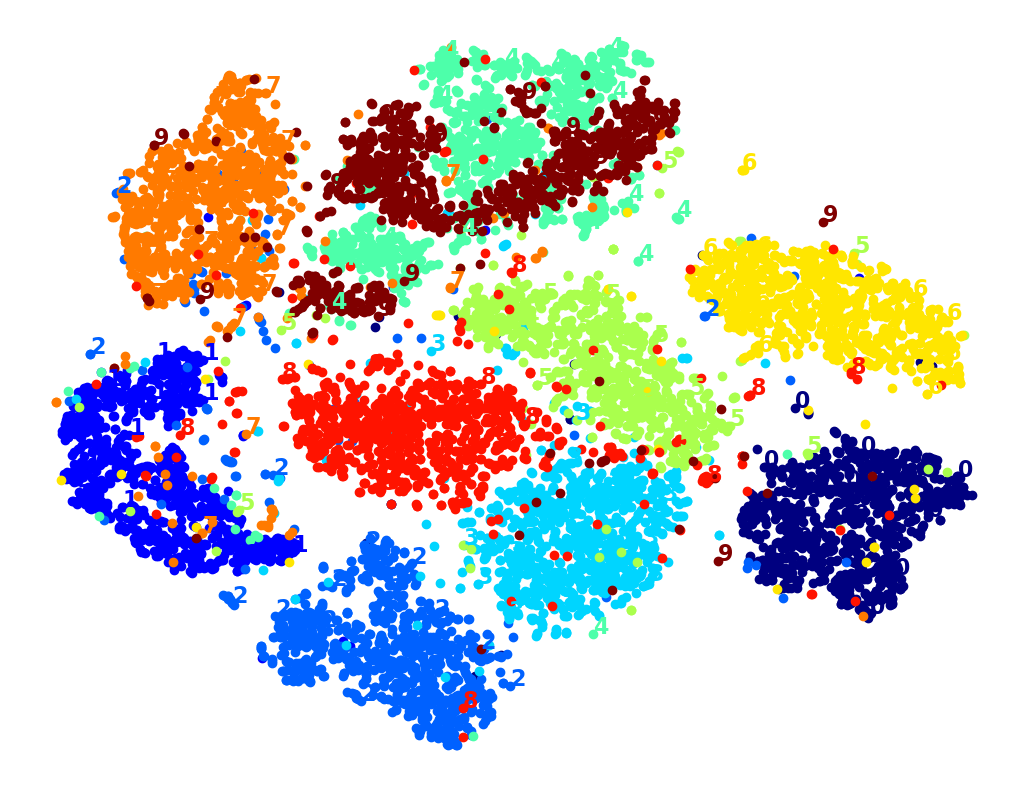

In [124]:
plot_digits(X_reduced, y)

Well that's okay, but not that beautiful. Let's try with the digit images:

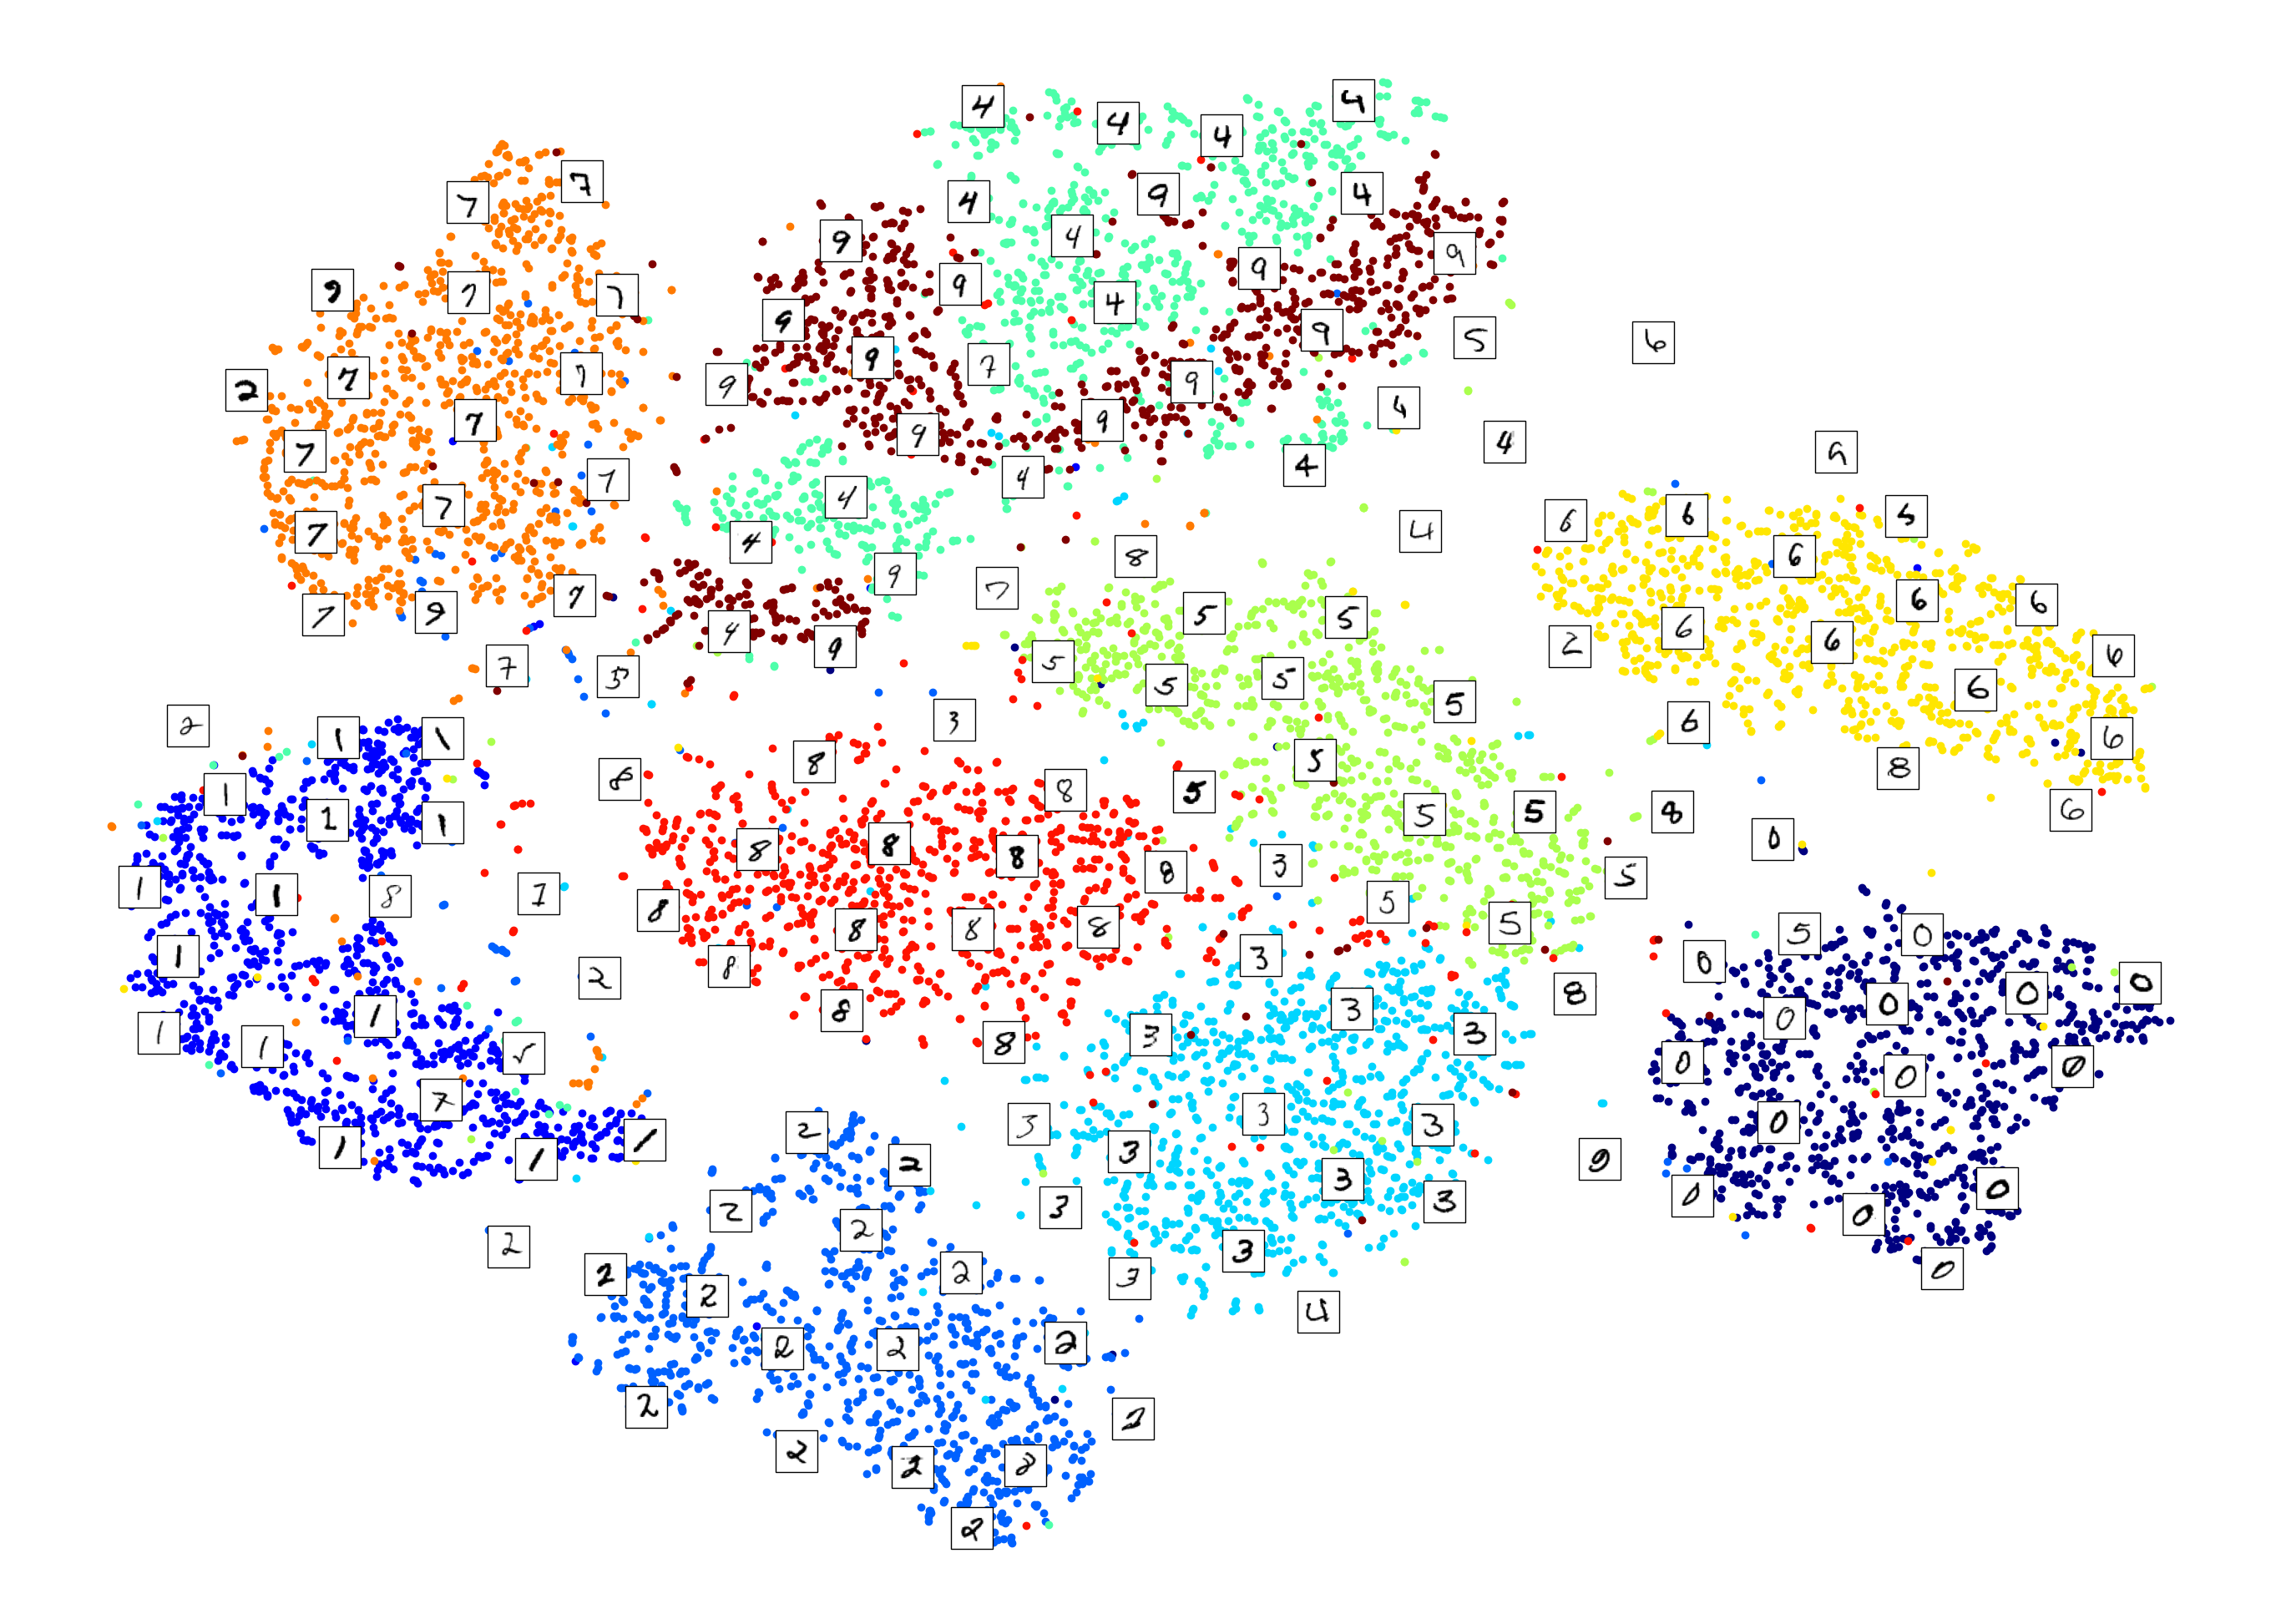

In [125]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

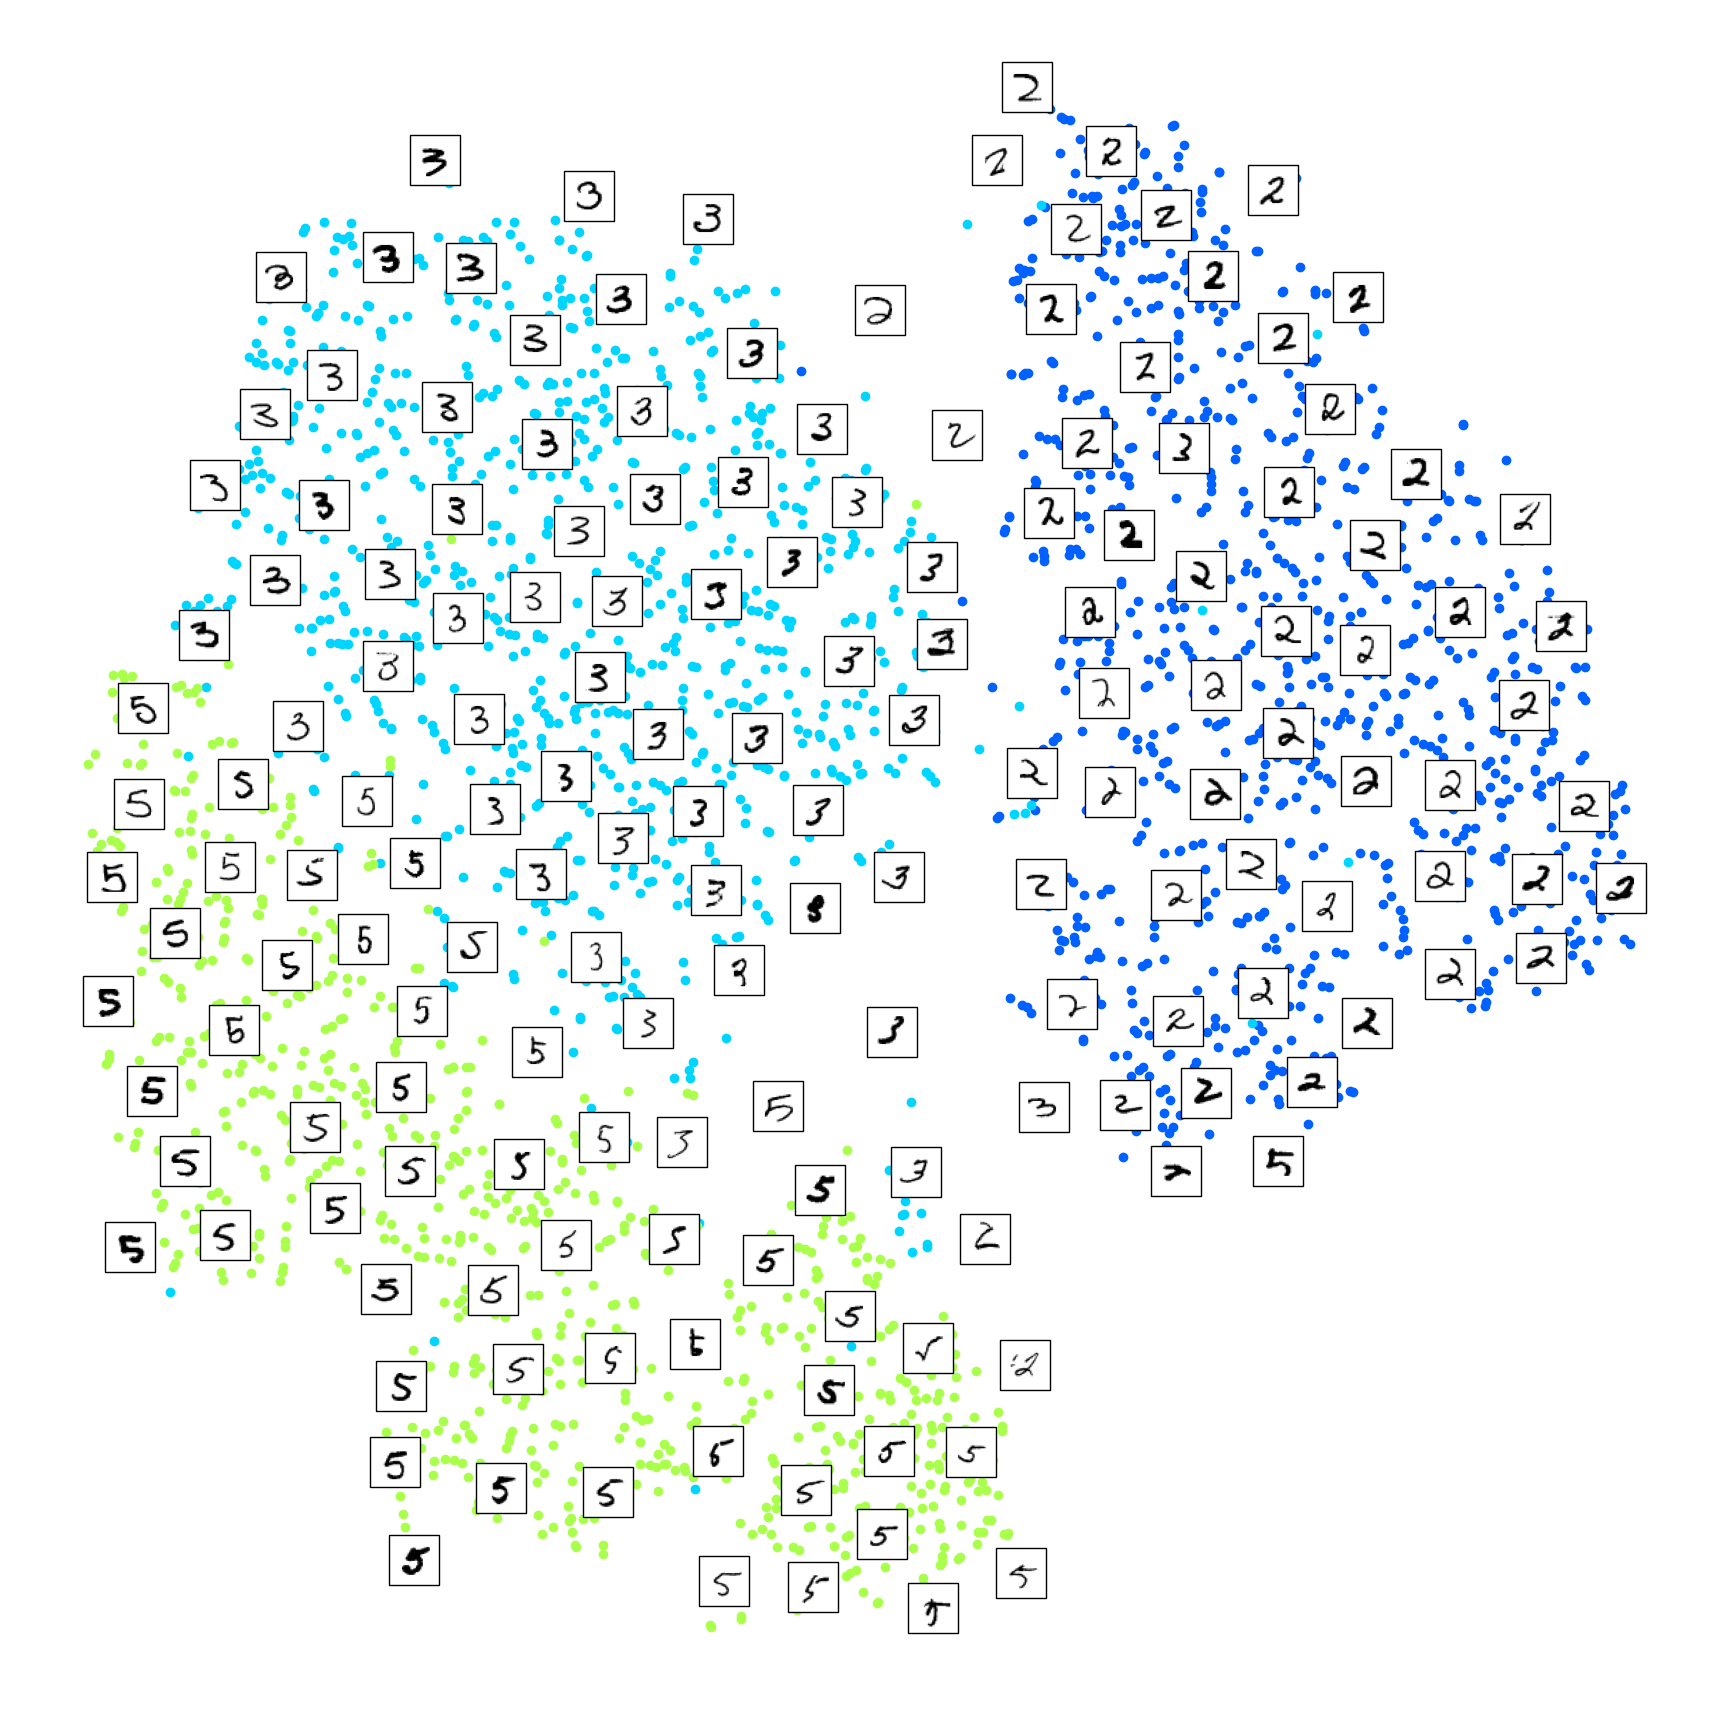

In [126]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

*Exercise: Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.*

Let's start with PCA. We will also time how long it takes:

PCA took 0.2s.


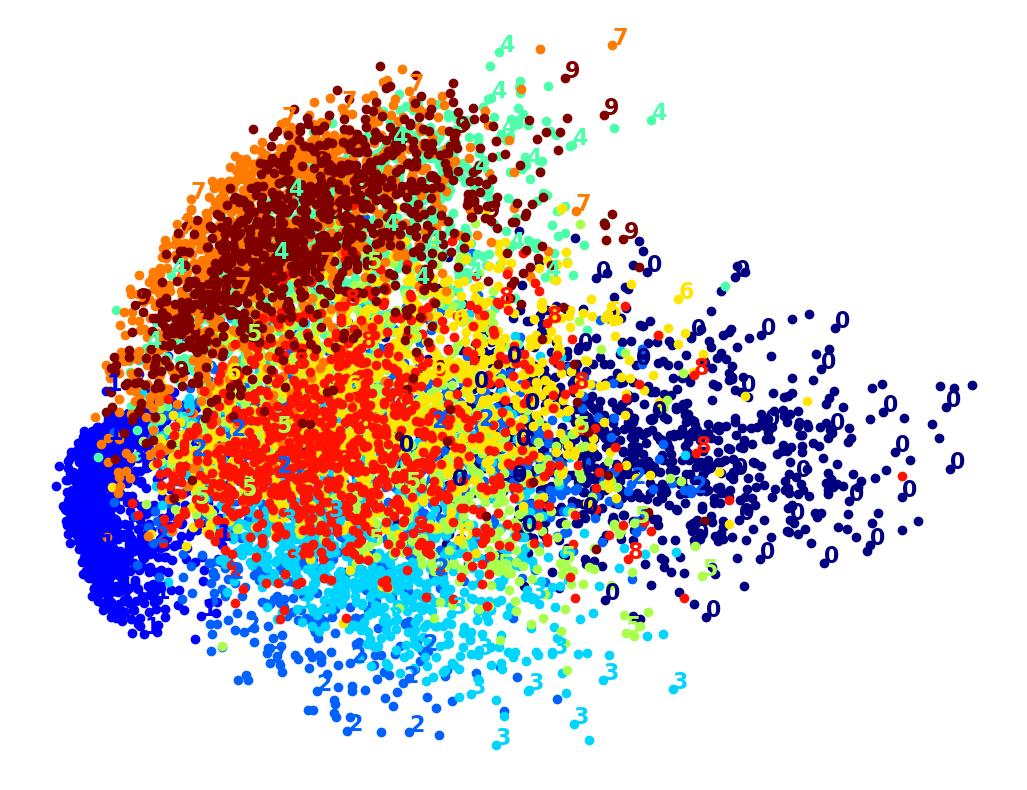

In [127]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

Wow, PCA is blazingly fast! But although we do see a few clusters, there's way too much overlap. Let's try LLE:

LLE took 22.9s.


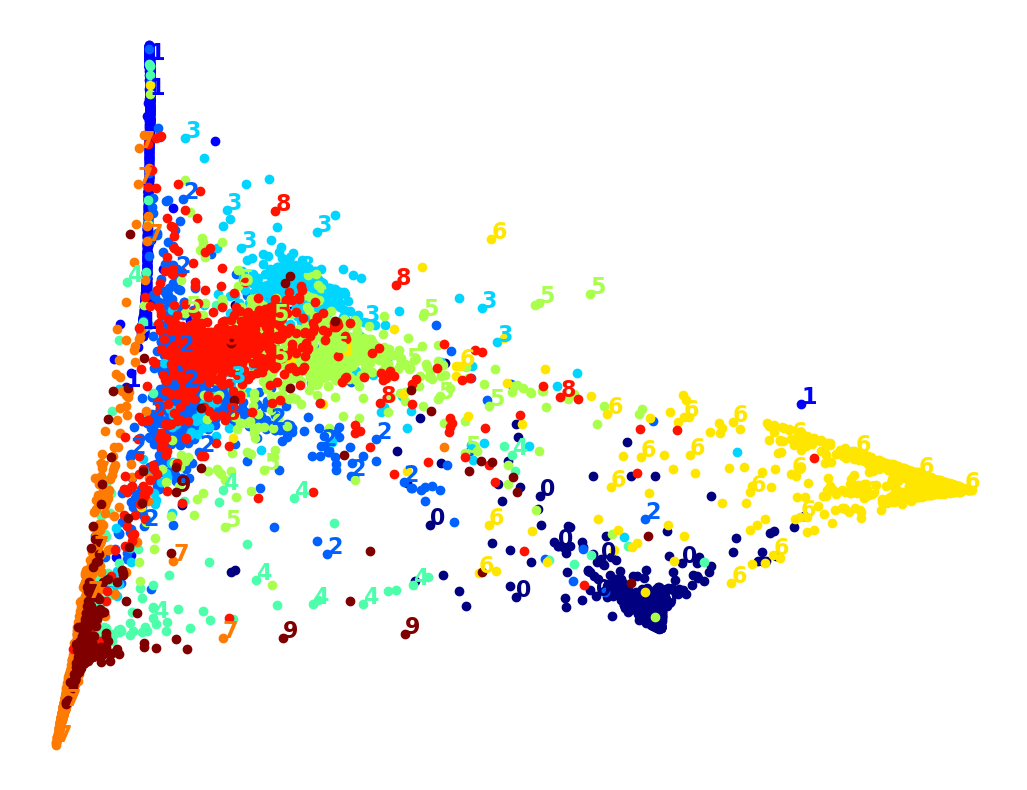

In [128]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

That took a while, and the result does not look too good. Let's see what happens if we apply PCA first, preserving 95% of the variance:

PCA+LLE took 25.8s.


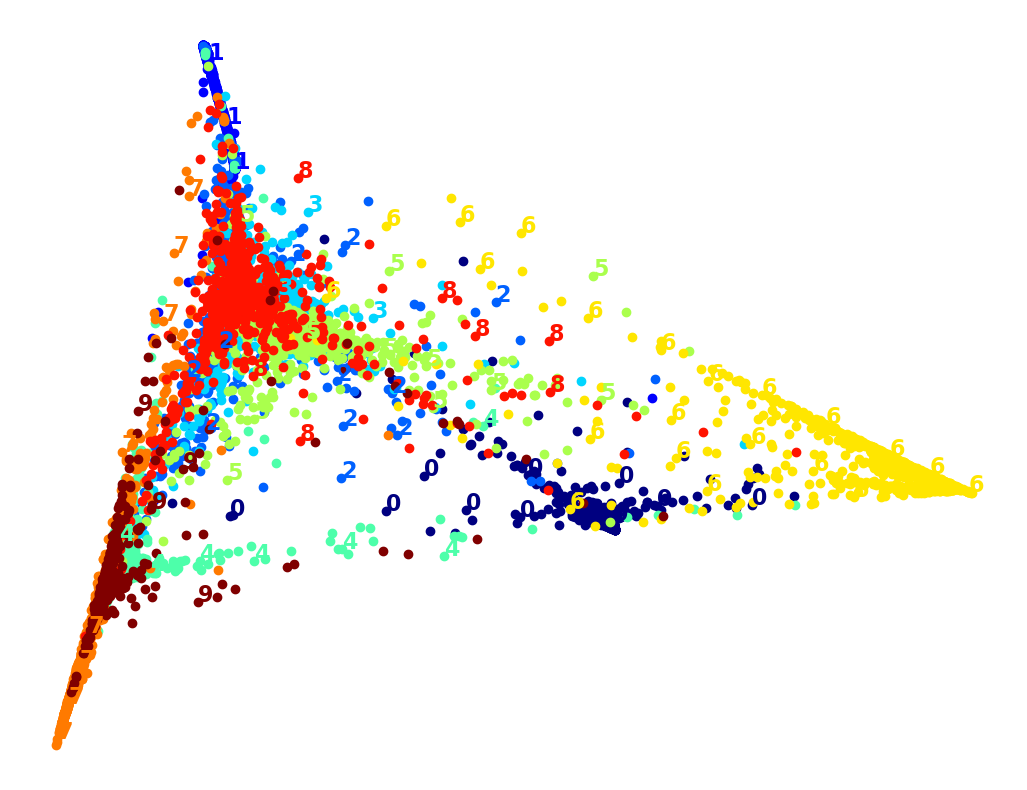

In [130]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("PCA+LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

The result is more or less the same, but this time it was almost 4× faster.

Let's try MDS. It's much too long if we run it on 10,000 instances, so let's just try 2,000 for now:

C:\Users\周悦\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


MDS took 105.6s (on just 2,000 MNIST images instead of 10,000).


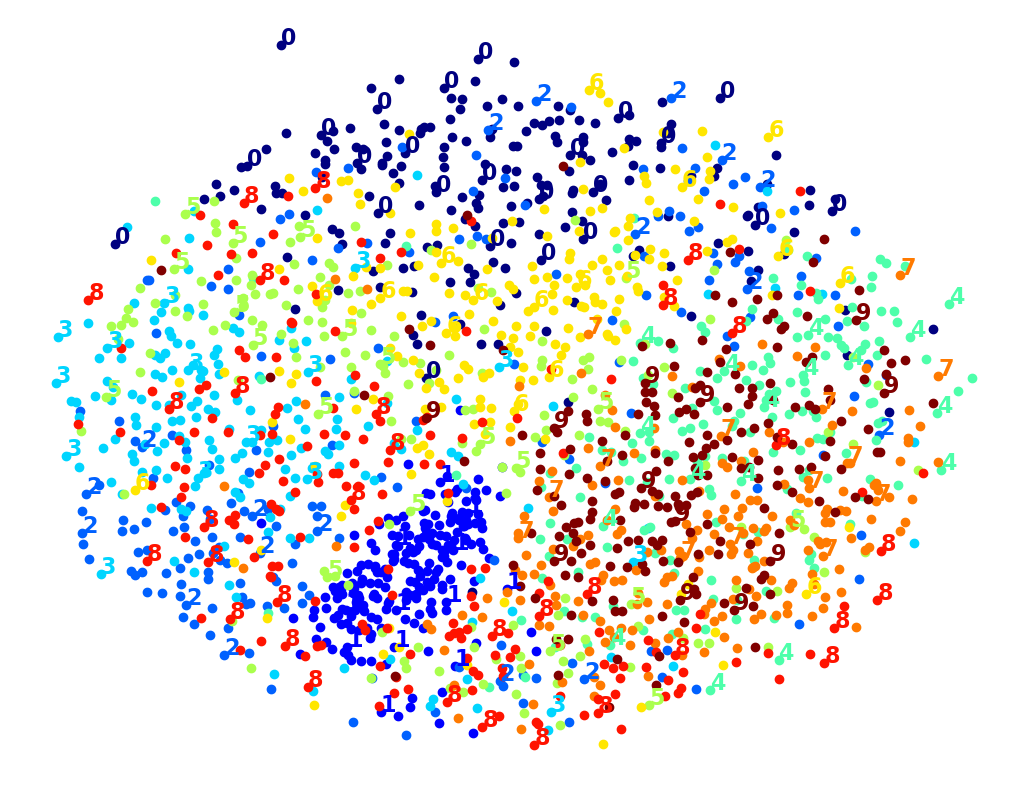

In [131]:
from sklearn.manifold import MDS

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = time.time()
print("MDS took {:.1f}s (on just 2,000 MNIST images instead of 10,000).".format(t1 - t0))
plot_digits(X_mds_reduced, y[:m])
plt.show()

Meh. This does not look great, all clusters overlap too much. Let's try with PCA first, perhaps it will be faster?

C:\Users\周悦\AppData\Roaming\Python\Python39\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PCA+MDS took 99.2s (on 2,000 MNIST images).


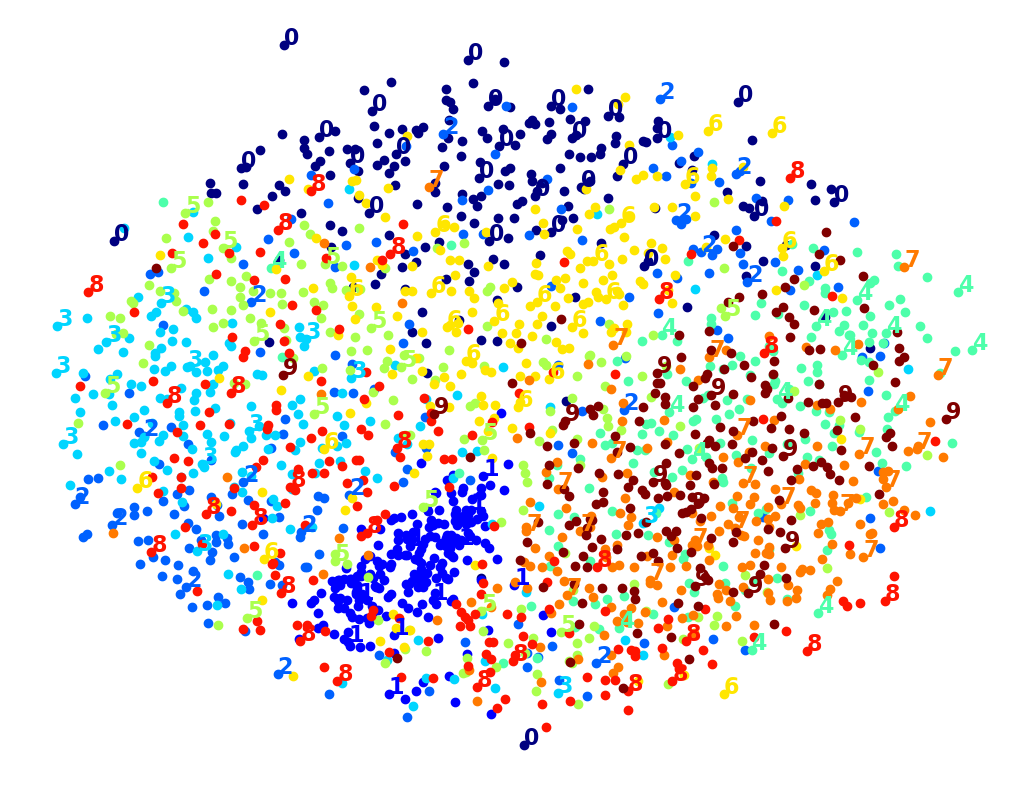

In [132]:
from sklearn.pipeline import Pipeline

pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()
print("PCA+MDS took {:.1f}s (on 2,000 MNIST images).".format(t1 - t0))
plot_digits(X_pca_mds_reduced, y[:2000])
plt.show()

Same result, and no speedup: PCA did not help (or hurt).

Let's try LDA:

LDA took 0.9s.


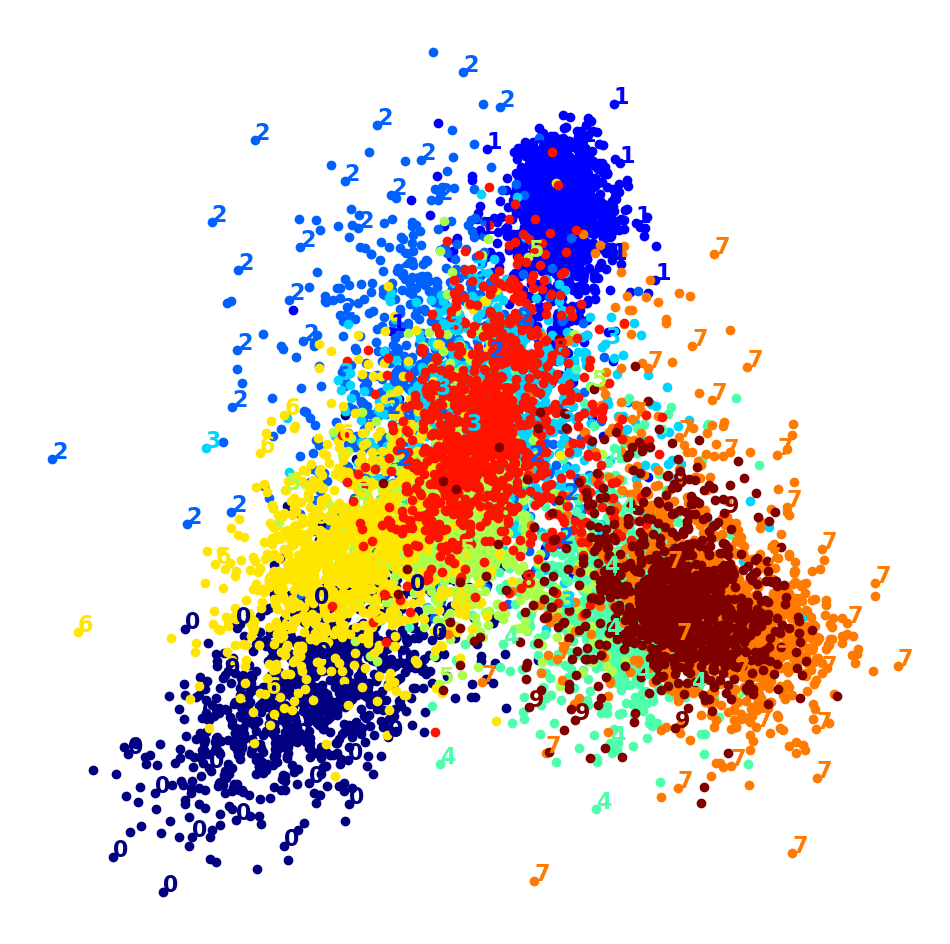

In [133]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print("LDA took {:.1f}s.".format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

This one is very fast, and it looks nice at first, until you realize that several clusters overlap severely.

Well, it's pretty clear that t-SNE won this little competition, wouldn't you agree? We did not time it, so let's do that now:

t-SNE took 39.5s.


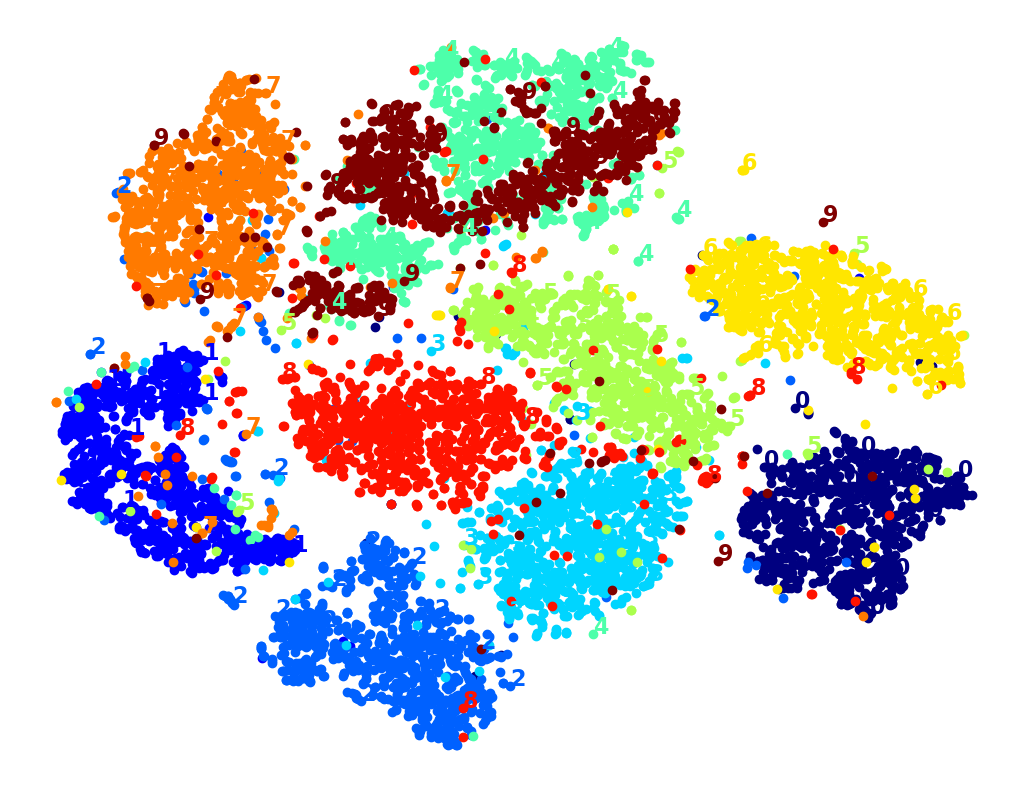

In [134]:
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y)
plt.show()

It's twice slower than LLE, but still much faster than MDS, and the result looks great. Let's see if a bit of PCA can speed it up:

PCA+t-SNE took 41.0s.


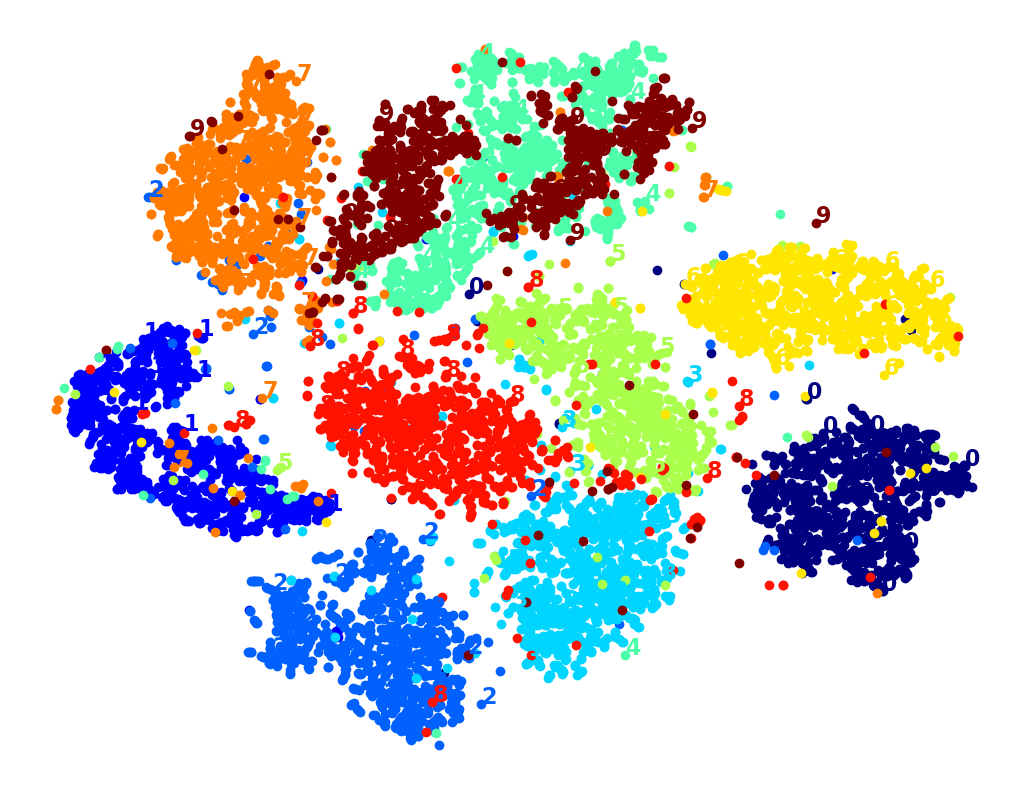

In [135]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()

Yes, PCA roughly gave us over 2x speedup, without damaging the result. We have a winner!